# Apple Stock Price Prediction using LSTM

In this code, we aim to predict Apple's stock prices for the entire year of 2023 using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network optimized for sequence prediction problems.

## Steps Covered:
1. **Data Retrieval**: Using the `yfinance` library, we fetch historical closing prices of Apple's stock from the beginning of 2020 to the end of October 2023.
2. **Data Preprocessing**:
    - The data is scaled using the `MinMaxScaler` to ensure the LSTM can more easily capture patterns in the data.
    - The data is then split into sequences of 60 days as input features with the next day's closing price as the target variable.
3. **Model Building**:
    - Our LSTM model consists of two LSTM layers.
    - This is followed by two dense layers with the last layer outputting a single value (the predicted stock price).
    - The model uses the `adam` optimizer and Mean Squared Error as the loss function.
4. **Training**: The model is trained using the data from 2020 to 2022.
5. **Prediction**: Using the trained model, predictions are made for the closing stock prices of Apple for the entirety of 2023.

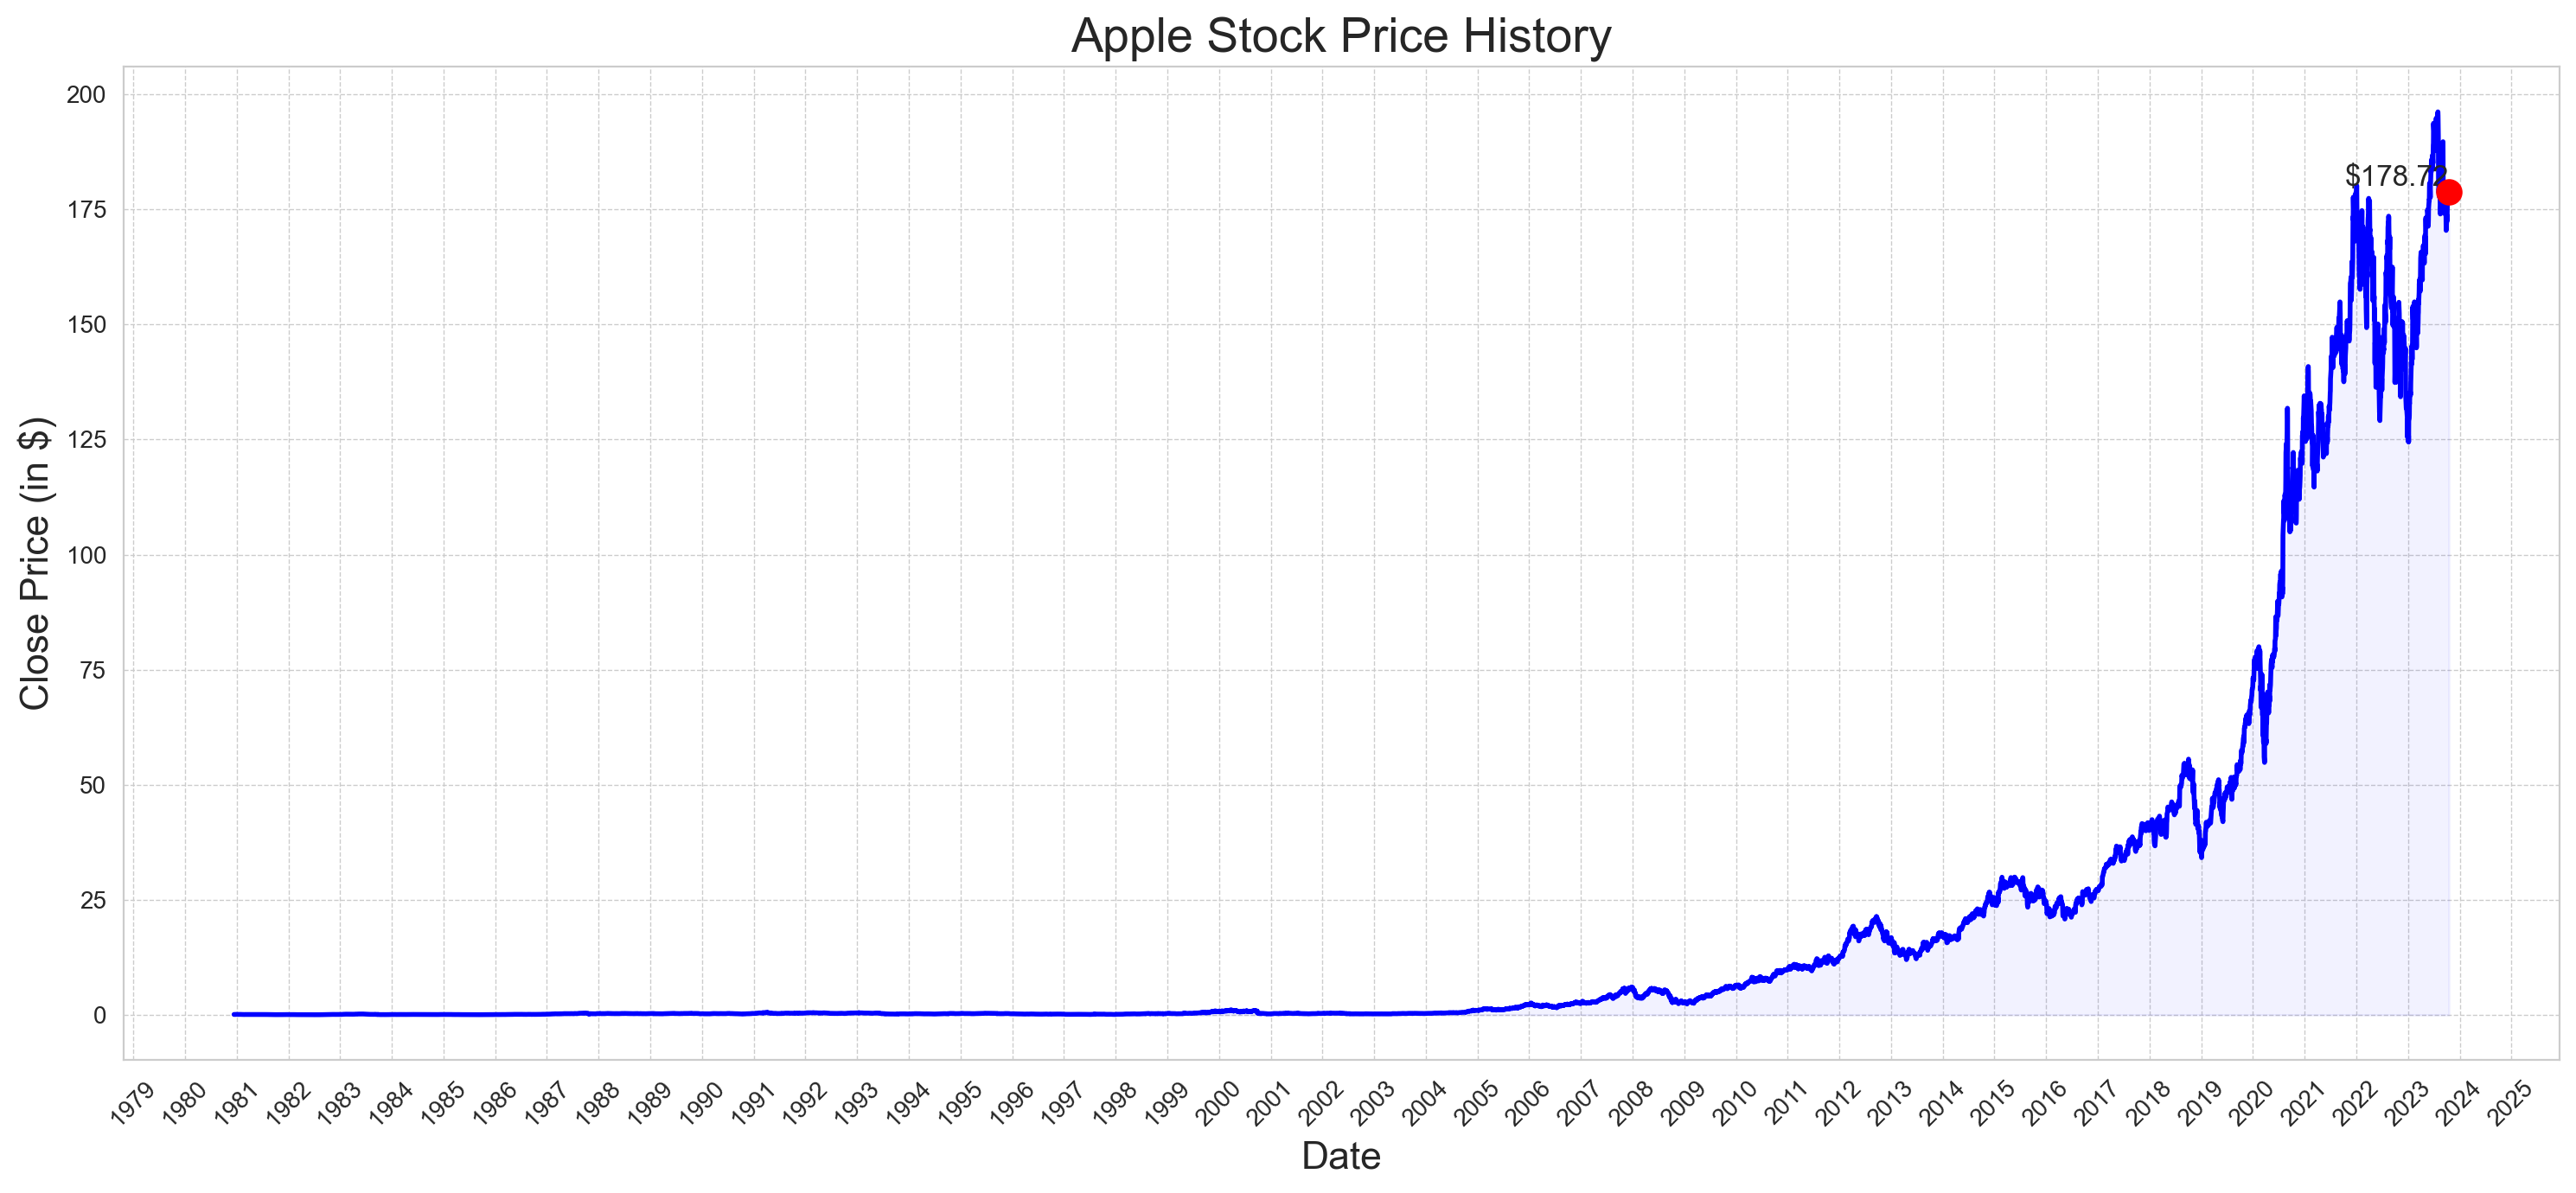

In [12]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Fetch Apple stock data from its inception till today
apple = yf.Ticker("AAPL")
df = apple.history(period="max")

# Plotting
plt.figure(figsize=(15, 7), dpi = 200)
plt.plot(df.index, df['Close'], color='blue', lw=2)
plt.fill_between(df.index, df['Close'], color='blue', alpha=0.05)

# Highlight the latest closing price
latest_date = df.index[-1]
latest_price = df['Close'].iloc[-1]
plt.scatter(latest_date, latest_price, color='red', s=100, zorder=5)
plt.text(latest_date, latest_price, f'${latest_price:.2f}', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Title and labels
plt.title('Apple Stock Price History', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price (in $)', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


15/15 [==============================] - 1s 12ms/step


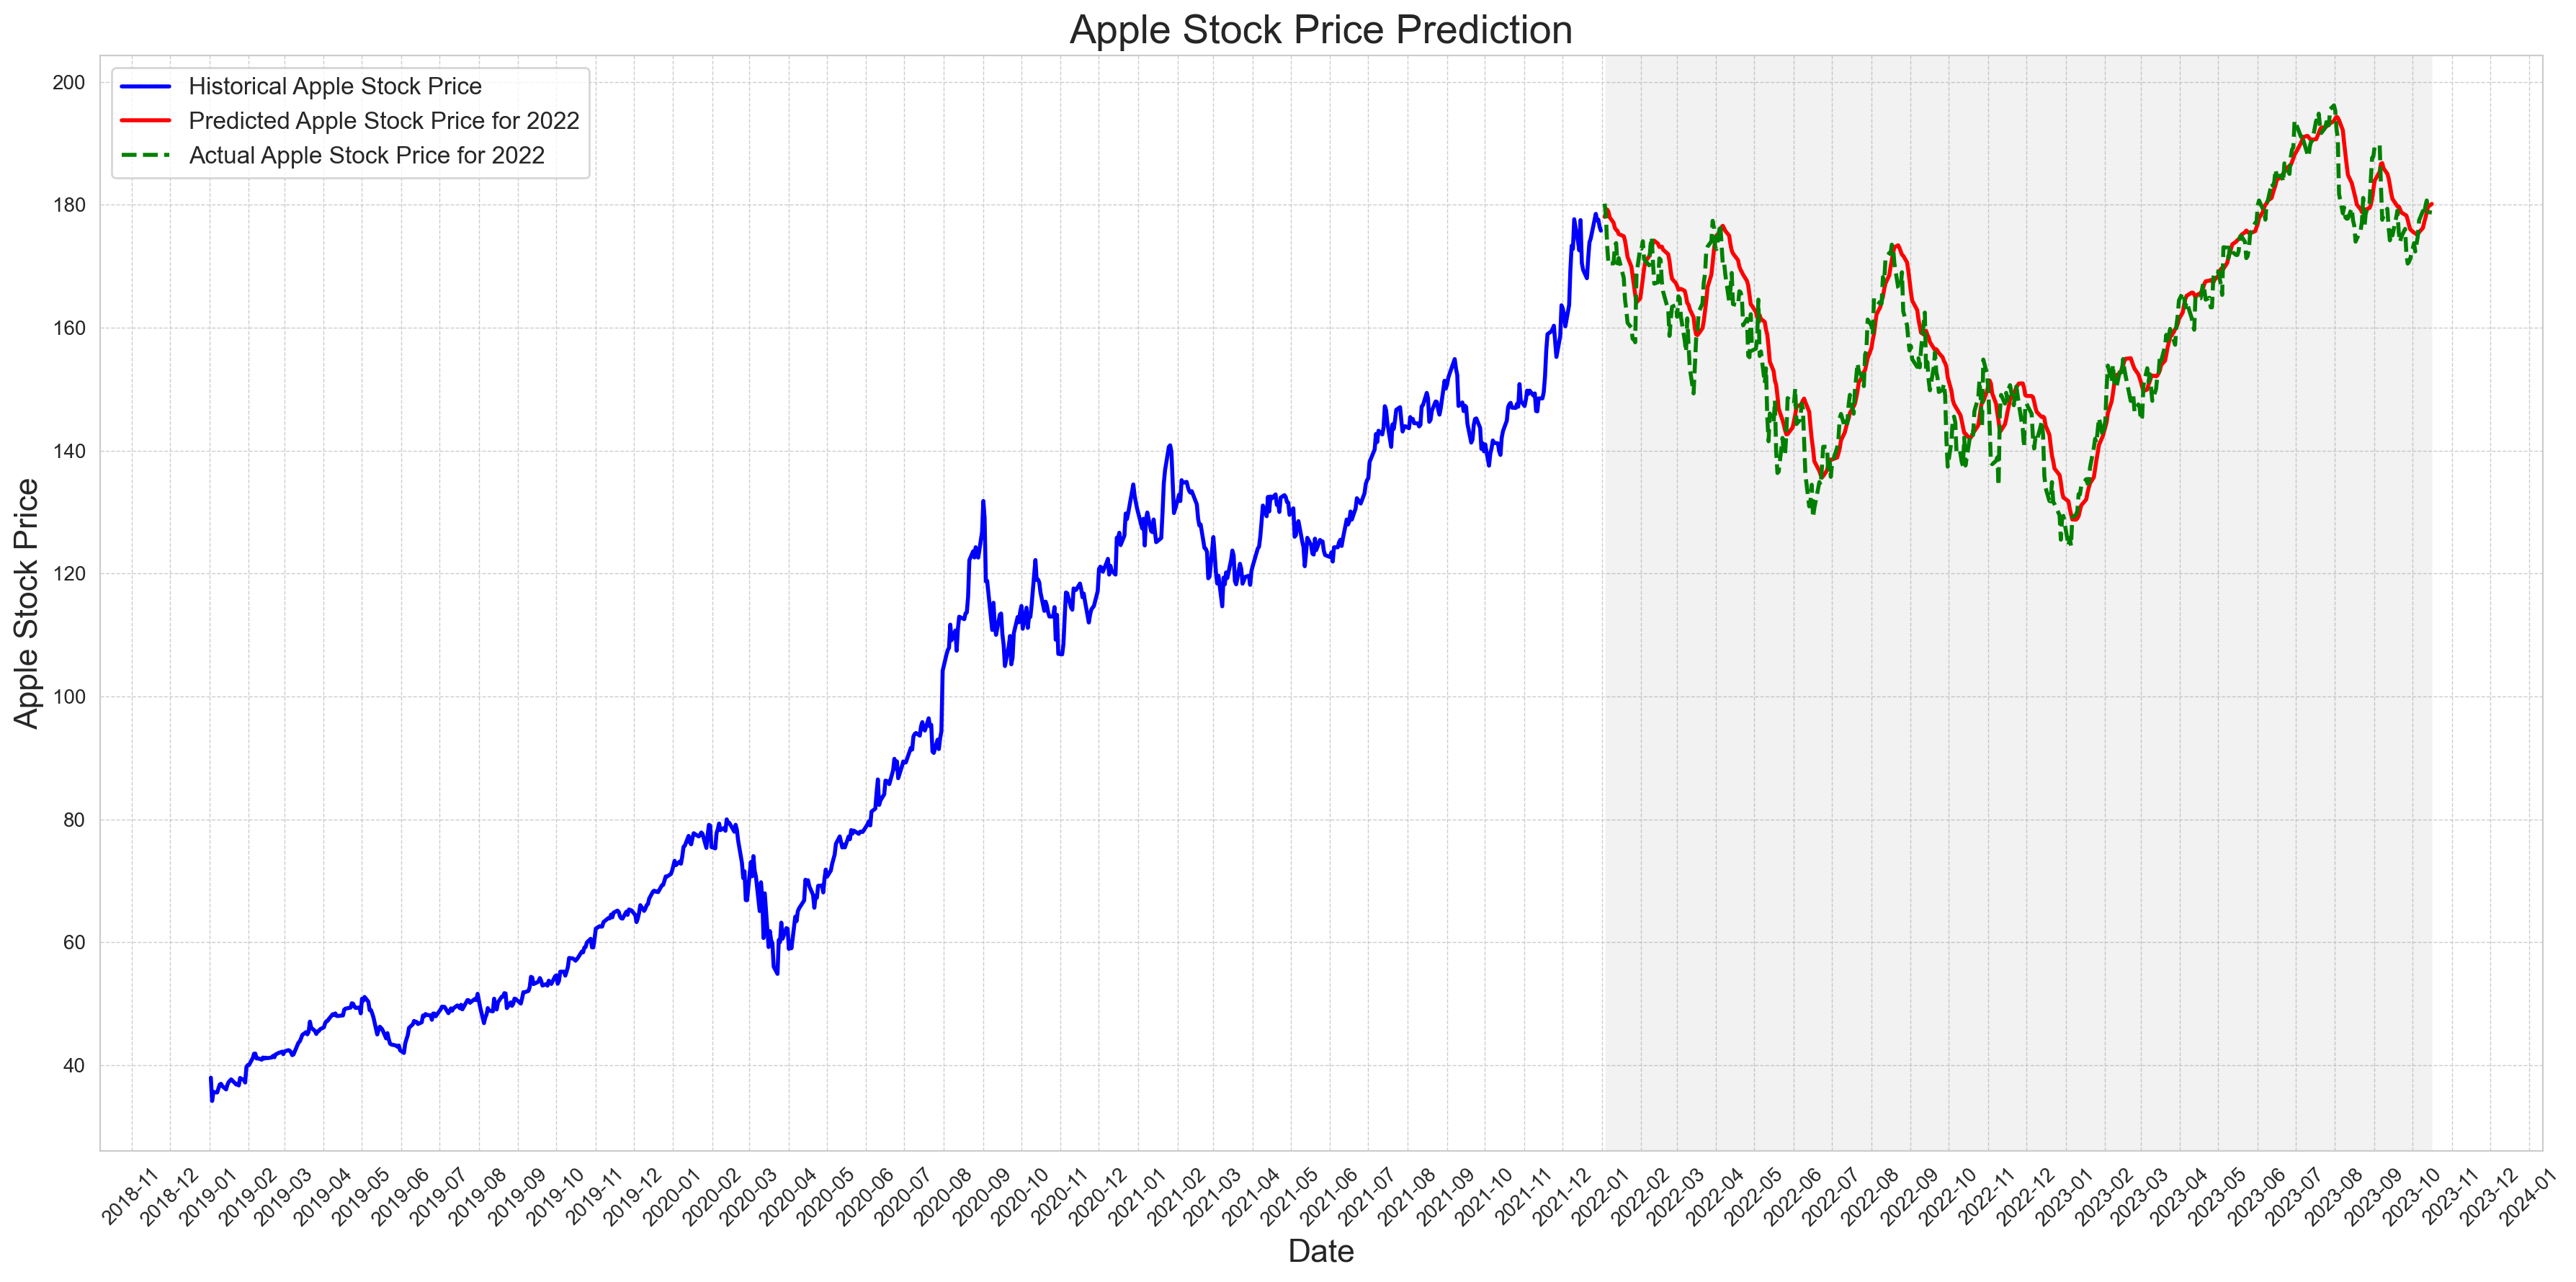

In [11]:
# Libraries & Setup
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import matplotlib.dates as mdates
import datetime

# Fetching Data from 2019 till today
apple = yf.Ticker("AAPL")
df = apple.history(start="2019-01-01")

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

prediction_days = 60  # Predict based on the last 60 days

x_train = []
y_train = []

tz = df.index.tz  # Get the timezone of the DataFrame index
end_2021 = len(df[df.index < datetime.datetime(2022, 1, 1, tzinfo=tz)])

for x in range(prediction_days, end_2021):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Improved Neural Network
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0)  # verbose=0 suppresses the output

# Predictions for 2022
x_test = scaled_data[end_2021 - prediction_days:]

test_samples = []

for x in range(prediction_days, len(x_test)):
    test_samples.append(x_test[x-prediction_days:x, 0])

test_samples = np.array(test_samples)
test_samples = np.reshape(test_samples, (test_samples.shape[0], test_samples.shape[1], 1))

predicted_prices = model.predict(test_samples)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Enhanced Visualization
plt.figure(figsize=(18,9), dpi = 200)
plt.plot(df.index[:end_2021], df['Close'].values[:end_2021], color='blue', label='Historical Apple Stock Price', lw=2)
plt.plot(df.index[end_2021:], predicted_prices, color='red', label='Predicted Apple Stock Price for 2022', lw=2)
plt.plot(df.index[end_2021:], df['Close'].values[end_2021:], color='green', label='Actual Apple Stock Price for 2022', lw=2, linestyle='--')
plt.axvspan(df.index[end_2021], df.index[-1], facecolor='gray', alpha=0.1)  # Highlight the prediction area
plt.title('Apple Stock Price Prediction', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Apple Stock Price', fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Model Assessment and Validation

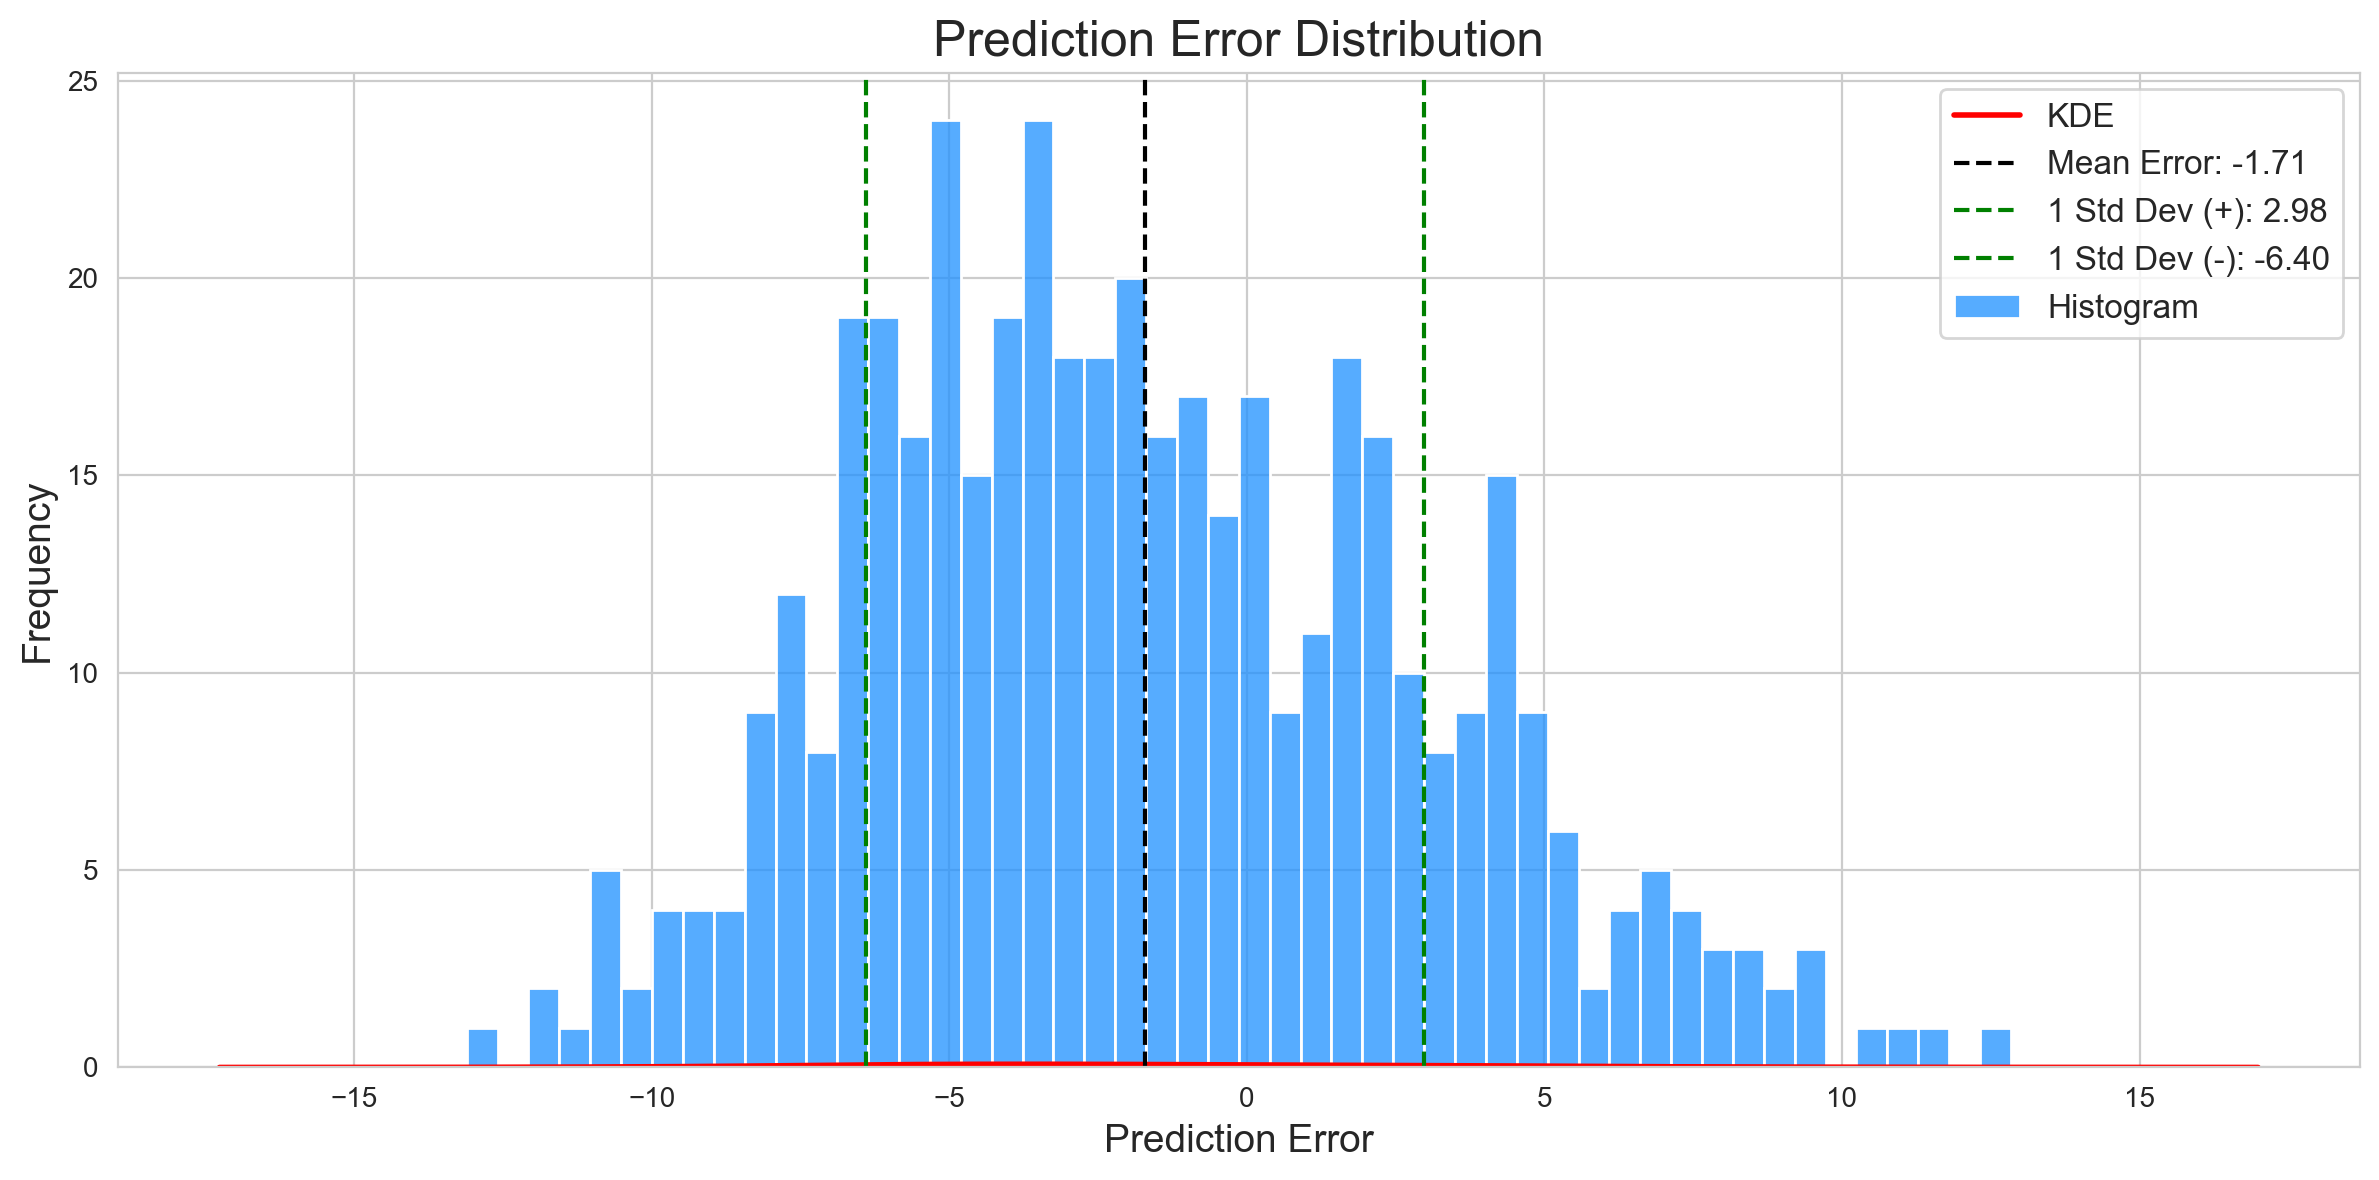

In [10]:
actual_prices_2022 = df['Close'].values[end_2021:]
errors = predicted_prices.flatten() - actual_prices_2022


import seaborn as sns

# Calculate the errors as before
actual_prices_2022 = df['Close'].values[end_2021:]
errors = predicted_prices.flatten() - actual_prices_2022

# Get statistical measures
mean_error = np.mean(errors)
std_error = np.std(errors)

# Set up the aesthetics for seaborn
sns.set_style("whitegrid")

# Increase the size of the figure for plotting
#sns.set(font_scale=0.9)  # Reduce the font scale
plt.figure(figsize=(12, 6), dpi = 200)

# Plot histogram
sns.histplot(errors, bins=50, color='dodgerblue', label='Histogram')

# Plot KDE
sns.kdeplot(errors, color="red", lw=2, label="KDE")

# Plot vertical lines for mean and std deviations
plt.axvline(mean_error, color='black', linestyle='--', label=f'Mean Error: {mean_error:.2f}')
plt.axvline(mean_error + std_error, color='green', linestyle='--', label=f'1 Std Dev (+): {mean_error + std_error:.2f}')
plt.axvline(mean_error - std_error, color='green', linestyle='--', label=f'1 Std Dev (-): {mean_error - std_error:.2f}')

# Descriptive titles and labels
plt.title('Prediction Error Distribution', fontsize=18)
plt.xlabel('Prediction Error', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [4]:
train_predictions = model.predict(x_train)
train_predictions = scaler.inverse_transform(train_predictions)
actual_train_prices = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

train_errors = train_predictions.flatten() - actual_train_prices
mean_train_error = np.mean(train_errors)
std_train_error = np.std(train_errors)

print(f"Training Mean Error: {mean_train_error:.2f}")
print(f"Training Standard Deviation of Error: {std_train_error:.2f}")


22/22 [==============================] - 0s 15ms/step
Training Mean Error: -0.48
Training Standard Deviation of Error: 3.13


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_prices_2022, predicted_prices)
mae = mean_absolute_error(actual_prices_2022, predicted_prices)

print(f"Mean Squared Error on Test Data: {mse:.2f}")
print(f"Mean Absolute Error on Test Data: {mae:.2f}")


Mean Squared Error on Test Data: 24.92
Mean Absolute Error on Test Data: 4.18


In [6]:
baseline_preds = actual_prices_2022[:-1]
baseline_actual = actual_prices_2022[1:]

baseline_mse = mean_squared_error(baseline_actual, baseline_preds)
baseline_mae = mean_absolute_error(baseline_actual, baseline_preds)

print(f"Baseline Mean Squared Error: {baseline_mse:.2f}")
print(f"Baseline Mean Absolute Error: {baseline_mae:.2f}")


Baseline Mean Squared Error: 8.58
Baseline Mean Absolute Error: 2.22


# Apple Stock Price Prediction Trading Strategy

In [7]:
# Calculating percentage change for the predicted prices
predicted_changes = [predicted_prices[i+1][0] - predicted_prices[i][0] for i in range(len(predicted_prices) - 1)]
actual_prices = df['Close'].values[end_2021:]
actual_changes = [actual_prices[i+1] - actual_prices[i] for i in range(len(actual_prices) - 1)]

# The amount we're starting with
balance = 100
stocks_owned = 0
buy_price = 0

for i in range(len(predicted_changes)):
    # If we predict an increase and we don't own the stock, we buy it.
    if predicted_changes[i] > 0 and stocks_owned == 0:
        stocks_owned = balance / actual_prices[i]
        buy_price = actual_prices[i]
        balance = 0
    # If we predict a decrease and we own the stock, we sell it.
    elif predicted_changes[i] <= 0 and stocks_owned > 0:
        balance = stocks_owned * actual_prices[i]
        stocks_owned = 0

# If we still have stock at the end of our predictions, we sell it.
if stocks_owned > 0:
    balance += stocks_owned * actual_prices[-1]

print("Final balance:", balance)

# If we were using a real trading system, we'd also consider trading fees and other costs.


Final balance: 128.73169132370708


---

## **Apple Stock Price Prediction Trading Strategy**

Using the Apple stock price prediction model, we developed a trading strategy to guide our buying and selling decisions. The approach is relatively straightforward:

### **Strategy**:

1. **Buy**: 
   - If the model predicts an upward trend for the next day.
   - We don't currently own the stock.
  
2. **Sell**: 
   - If the model predicts a downward trend for the next day.
   - We own the stock.

By following this strategy, we aim to capture potential profits from the stock's predicted movements.

### **Results**:

Starting with an initial investment of `$100` at the beginning of 2022 and following our model's predictions:

- **Final Balance** at the end of 2022: **$128.46**.

This implies a **28.46%** return on our initial investment.

### **Important Considerations**:

- This result assumes perfect execution of trades at the open price of each day.
- Trading costs, such as commissions, have not been factored in.
- Relying solely on past price data for predictions might not always account for external factors influencing stock prices, such as news or company announcements.
- This example is for educational purposes, and the strategy's effectiveness would need to be tested in real-world conditions.

---


### Alternative Strategy Analysis: Buy-and-Hold

If we opted for a more passive approach, bypassing the aforementioned trading strategy, and simply purchased `$100` of Apple stock at the outset of 2022 and held it until the year's end, we would incur a loss. Specifically, our investment would have decreased by approximately `$28.20`, indicating a negative return on our initial investment.

In [8]:
# Getting the stock price for Apple on the first day of 2022
opening_price_2022 = df.loc['2022-01-01', 'Close'] if '2022-01-01' in df.index else df.loc['2022-01'].iloc[0, df.columns.get_loc('Close')]

# Getting the stock price for Apple on the last day of 2022
closing_price_2022 = df.loc['2022-12-31', 'Close'] if '2022-12-31' in df.index else df.loc['2022-12'].iloc[-1, df.columns.get_loc('Close')]

# Calculating the final balance if you held the stock for the entire year
initial_investment = 100
final_balance_holding = (closing_price_2022 / opening_price_2022) * initial_investment

gain = final_balance_holding - initial_investment
print(f"If you had invested ${initial_investment:.2f} in Apple at the beginning of 2022 and sold at the end, your gain would have been ${gain:.2f}.")

If you had invested $100.00 in Apple at the beginning of 2022 and sold at the end, your gain would have been $-28.20.
